In [ ]:
!pip install opencv-python-headless matplotlib tensorflow
!pip install -q kaggle

In [ ]:
from google.colab import userdata
import os

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical

In [ ]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d ziya07/multi-class-fabric-defect-detection-dataset
!unzip -q multi-class-fabric-defect-detection-dataset.zip -d fabric_data

Dataset URL: https://www.kaggle.com/datasets/ziya07/multi-class-fabric-defect-detection-dataset
License(s): CC0-1.0
 96% 2.01G/2.10G [00:27<00:03, 25.3MB/s]
100% 2.10G/2.10G [00:27<00:00, 83.2MB/s]


Classes: ['Broken stitch', 'Needle mark', 'Pinched fabric', 'Vertical', 'defect free', 'hole', 'horizontal', 'lines', 'stain']


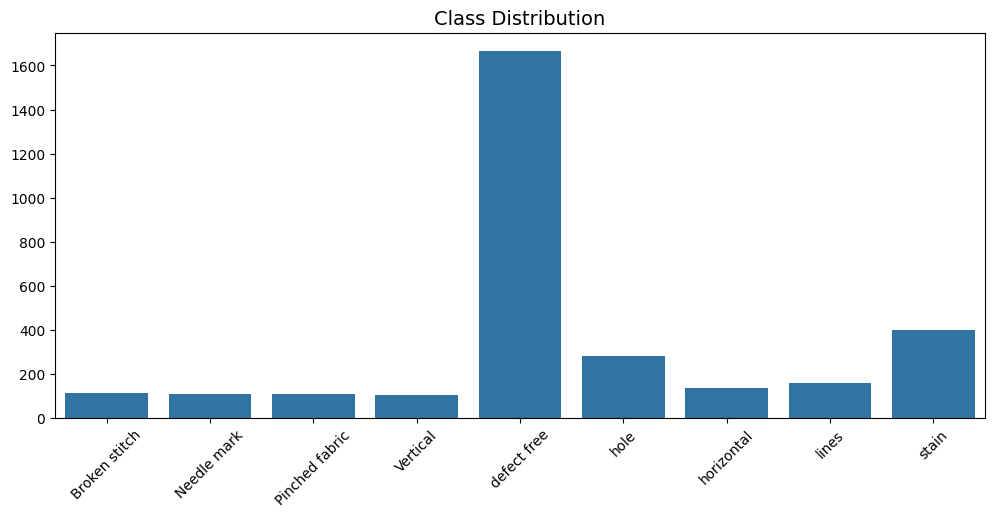

In [ ]:
data_dir = '/content/fabric_data/Dataset'
classes = sorted(os.listdir(data_dir))
print("Classes:", classes)
class_counts = {cls: len(os.listdir(f"{data_dir}/{cls}")) for cls in classes}
plt.figure(figsize=(12, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40  # Increased for better convergence

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

# Generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Class weights
y_train = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Found 2457 images belonging to 9 classes.
Found 610 images belonging to 9 classes.
Class weights: {0: np.float64(3.033333333333333), 1: np.float64(3.1379310344827585), 2: np.float64(3.1379310344827585), 3: np.float64(3.3703703703703702), 4: np.float64(0.204801200300075), 5: np.float64(1.2133333333333334), 6: np.float64(2.5045871559633026), 7: np.float64(2.1666666666666665), 8: np.float64(0.8557993730407524)}


In [ ]:
def create_enhanced_model():
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        include_top=False,
        weights='imagenet',
        alpha=0.5  # More capacity than 0.35
    )

    # Unfreeze top layers
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)  # Additional layer
    x = layers.Dropout(0.5)(x)  # Increased dropout
    outputs = layers.Dense(len(classes), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower LR
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    return model

model = create_enhanced_model()
model.summary()

# ----------------------
# TRAINING WITH CALLBACKS
# ----------------------
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    )
]

3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.50_224            │ (None, 7, 7, 1280)     │       706,224 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,353 (3.32 MB)

 Trainable params: 852,809 (3.25 MB)

 Non-trainable params: 18,544 (72.44 KB)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4909 - loss: 2.0154 - precision: 0.7272 - recall: 0.2292

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.4924 - loss: 2.0100 - precision: 0.7288 - recall: 0.2310 - val_accuracy: 0.1990 - val_loss: 1.9875 - val_precision: 0.6190 - val_recall: 0.0214 - learning_rate: 1.0000e-04
Epoch 2/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7188 - loss: 2.0851 - precision: 0.9048 - recall: 0.5938

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.7188 - loss: 2.0851 - precision: 0.9048 - recall: 0.5938 - val_accuracy: 0.2023 - val_loss: 1.9800 - val_precision: 0.6923 - val_recall: 0.0296 - learning_rate: 1.0000e-04
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.7963 - loss: 0.9867 - precision: 0.8808 - recall: 0.6659

76/76 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.7963 - loss: 0.9857 - precision: 0.8807 - recall: 0.6663 - val_accuracy: 0.2763 - val_loss: 1.8065 - val_precision: 0.5733 - val_recall: 0.0707 - learning_rate: 1.0000e-04
Epoch 4/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8125 - loss: 0.8074 - precision: 0.8333 - recall: 0.7812

76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - accuracy: 0.8125 - loss: 0.8074 - precision: 0.8333 - recall: 0.7812 - val_accuracy: 0.2944 - val_loss: 1.7998 - val_precision: 0.5400 - val_recall: 0.0888 - learning_rate: 1.0000e-04
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.8303 - loss: 0.7627 - precision: 0.8753 - recall: 0.7768

76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8304 - loss: 0.7621 - precision: 0.8753 - recall: 0.7770 - val_accuracy: 0.3207 - val_loss: 1.6535 - val_precision: 0.4124 - val_recall: 0.1201 - learning_rate: 1.0000e-04
Epoch 6/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.7812 - loss: 0.9341 - precision: 0.8214 - recall: 0.7188

76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.7812 - loss: 0.9341 - precision: 0.8214 - recall: 0.7188 - val_accuracy: 0.3240 - val_loss: 1.6723 - val_precision: 0.3646 - val_recall: 0.1151 - learning_rate: 1.0000e-04
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8297 - loss: 0.6884 - precision: 0.8695 - recall: 0.7880 - val_accuracy: 0.3059 - val_loss: 1.6005 - val_precision: 0.3655 - val_recall: 0.1743 - learning_rate: 1.0000e-04
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.9688 - loss: 0.3881 - precision: 0.9667 - recall: 0.9062 - val_accuracy: 0.2961 - val_loss: 1.6665 - val_precision: 0.3497 - val_recall: 0.1760 - learning_rate: 1.0000e-04
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8710 - loss: 0.5731 - precision: 0.8899 - recall: 0.8376 - val_accuracy: 0.3109 - val_loss: 1.6292 - val_precision: 0.3157 - val_recall: 0.2155 - learning_rate: 1.0000e-04
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - acc

76/76 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8879 - loss: 0.4625 - precision: 0.9021 - recall: 0.8605 - val_accuracy: 0.3454 - val_loss: 1.4932 - val_precision: 0.3661 - val_recall: 0.2632 - learning_rate: 1.0000e-04
Epoch 12/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.8125 - loss: 0.6770 - precision: 0.8276 - recall: 0.7500 - val_accuracy: 0.3257 - val_loss: 1.5174 - val_precision: 0.3605 - val_recall: 0.2549 - learning_rate: 1.0000e-04
Epoch 13/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.8824 - loss: 0.4897 - precision: 0.9014 - recall: 0.8689

76/76 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8825 - loss: 0.4894 - precision: 0.9014 - recall: 0.8689 - val_accuracy: 0.3503 - val_loss: 1.4279 - val_precision: 0.3933 - val_recall: 0.2697 - learning_rate: 1.0000e-04
Epoch 14/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9688 - loss: 0.2396 - precision: 1.0000 - recall: 0.9375

76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.9688 - loss: 0.2396 - precision: 1.0000 - recall: 0.9375 - val_accuracy: 0.3701 - val_loss: 1.4335 - val_precision: 0.4067 - val_recall: 0.2977 - learning_rate: 1.0000e-04
Epoch 15/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9013 - loss: 0.3917 - precision: 0.9132 - recall: 0.8861 - val_accuracy: 0.3322 - val_loss: 1.3971 - val_precision: 0.3786 - val_recall: 0.2796 - learning_rate: 1.0000e-04
Epoch 16/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8125 - loss: 0.6148 - precision: 0.8276 - recall: 0.7500

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.8125 - loss: 0.6148 - precision: 0.8276 - recall: 0.7500 - val_accuracy: 0.3898 - val_loss: 1.3142 - val_precision: 0.3955 - val_recall: 0.2895 - learning_rate: 1.0000e-04
Epoch 17/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9000 - loss: 0.3699 - precision: 0.9156 - recall: 0.8749

76/76 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9000 - loss: 0.3701 - precision: 0.9157 - recall: 0.8749 - val_accuracy: 0.3964 - val_loss: 1.3627 - val_precision: 0.4196 - val_recall: 0.3306 - learning_rate: 1.0000e-04
Epoch 18/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9688 - loss: 0.2056 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.3964 - val_loss: 1.3390 - val_precision: 0.4122 - val_recall: 0.3322 - learning_rate: 1.0000e-04
Epoch 19/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.9215 - loss: 0.2839 - precision: 0.9248 - recall: 0.9053

76/76 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9214 - loss: 0.2842 - precision: 0.9248 - recall: 0.9052 - val_accuracy: 0.5214 - val_loss: 1.0569 - val_precision: 0.5466 - val_recall: 0.4342 - learning_rate: 1.0000e-04
Epoch 20/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8438 - loss: 0.3173 - precision: 0.8438 - recall: 0.8438

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step - accuracy: 0.8438 - loss: 0.3173 - precision: 0.8438 - recall: 0.8438 - val_accuracy: 0.5444 - val_loss: 1.0366 - val_precision: 0.5676 - val_recall: 0.4556 - learning_rate: 1.0000e-04
Epoch 21/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9048 - loss: 0.3298 - precision: 0.9146 - recall: 0.8915 - val_accuracy: 0.5148 - val_loss: 1.0724 - val_precision: 0.5572 - val_recall: 0.4408 - learning_rate: 1.0000e-04
Epoch 22/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.8438 - loss: 0.7614 - precision: 0.8438 - recall: 0.8438 - val_accuracy: 0.5181 - val_loss: 1.0502 - val_precision: 0.5690 - val_recall: 0.4474 - learning_rate: 1.0000e-04
Epoch 23/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9236 - loss: 0.2880 - precision: 0.9330 - recall: 0.9111

76/76 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9235 - loss: 0.2885 - precision: 0.9328 - recall: 0.9110 - val_accuracy: 0.6234 - val_loss: 0.9343 - val_precision: 0.6576 - val_recall: 0.5148 - learning_rate: 1.0000e-04
Epoch 24/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.9062 - loss: 0.4655 - precision: 0.9032 - recall: 0.8750 - val_accuracy: 0.6086 - val_loss: 0.9134 - val_precision: 0.6557 - val_recall: 0.5230 - learning_rate: 1.0000e-04
Epoch 25/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9173 - loss: 0.3025 - precision: 0.9354 - recall: 0.9088 - val_accuracy: 0.6003 - val_loss: 0.9113 - val_precision: 0.6442 - val_recall: 0.5181 - learning_rate: 1.0000e-04
Epoch 26/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.9375 - loss: 0.4418 - precision: 0.9333 - recall: 0.8750 - val_accuracy: 0.6036 - val_loss: 0.9390 - val_precision: 0.6172 - val_recall: 0.5066 - learning_rate: 1.0000e-04
Epoch 27/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - acc

76/76 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9259 - loss: 0.2606 - precision: 0.9349 - recall: 0.9163 - val_accuracy: 0.6414 - val_loss: 0.9262 - val_precision: 0.6516 - val_recall: 0.5938 - learning_rate: 1.0000e-04
Epoch 32/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 1.0000 - loss: 0.1235 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6365 - val_loss: 0.8782 - val_precision: 0.6404 - val_recall: 0.6003 - learning_rate: 1.0000e-04
Epoch 33/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9367 - loss: 0.2251 - precision: 0.9423 - recall: 0.9265 - val_accuracy: 0.6414 - val_loss: 0.8753 - val_precision: 0.6596 - val_recall: 0.6184 - learning_rate: 1.0000e-04
Epoch 34/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9062 - loss: 0.6962 - precision: 0.9062 - recall: 0.9062

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.9062 - loss: 0.6962 - precision: 0.9062 - recall: 0.9062 - val_accuracy: 0.6628 - val_loss: 0.8297 - val_precision: 0.6719 - val_recall: 0.6365 - learning_rate: 2.0000e-05
Epoch 35/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.9319 - loss: 0.2544 - precision: 0.9390 - recall: 0.9287

76/76 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9319 - loss: 0.2543 - precision: 0.9390 - recall: 0.9286 - val_accuracy: 0.6727 - val_loss: 0.7988 - val_precision: 0.6860 - val_recall: 0.6431 - learning_rate: 2.0000e-05
Epoch 36/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9375 - loss: 0.2358 - precision: 0.9355 - recall: 0.9062

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.9375 - loss: 0.2358 - precision: 0.9355 - recall: 0.9062 - val_accuracy: 0.6826 - val_loss: 0.8008 - val_precision: 0.6955 - val_recall: 0.6612 - learning_rate: 2.0000e-05
Epoch 37/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9243 - loss: 0.2293 - precision: 0.9290 - recall: 0.9160 - val_accuracy: 0.6694 - val_loss: 0.8028 - val_precision: 0.6801 - val_recall: 0.6398 - learning_rate: 2.0000e-05
Epoch 38/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.9062 - loss: 0.2162 - precision: 0.9032 - recall: 0.8750 - val_accuracy: 0.6727 - val_loss: 0.7932 - val_precision: 0.6901 - val_recall: 0.6447 - learning_rate: 2.0000e-05
Epoch 39/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9312 - loss: 0.2436 - precision: 0.9402 - recall: 0.9222

76/76 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9312 - loss: 0.2436 - precision: 0.9402 - recall: 0.9222 - val_accuracy: 0.6842 - val_loss: 0.7738 - val_precision: 0.6965 - val_recall: 0.6530 - learning_rate: 2.0000e-05
Epoch 40/40
 1/76 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9688 - loss: 0.2432 - precision: 0.9688 - recall: 0.9688

76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.9688 - loss: 0.2432 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.7056 - val_loss: 0.7718 - val_precision: 0.7165 - val_recall: 0.6776 - learning_rate: 2.0000e-05


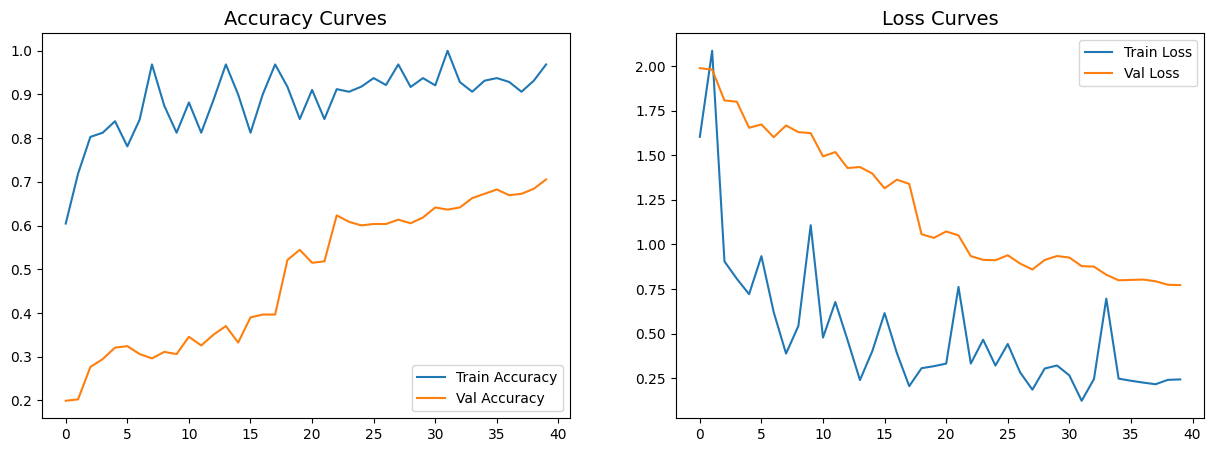

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


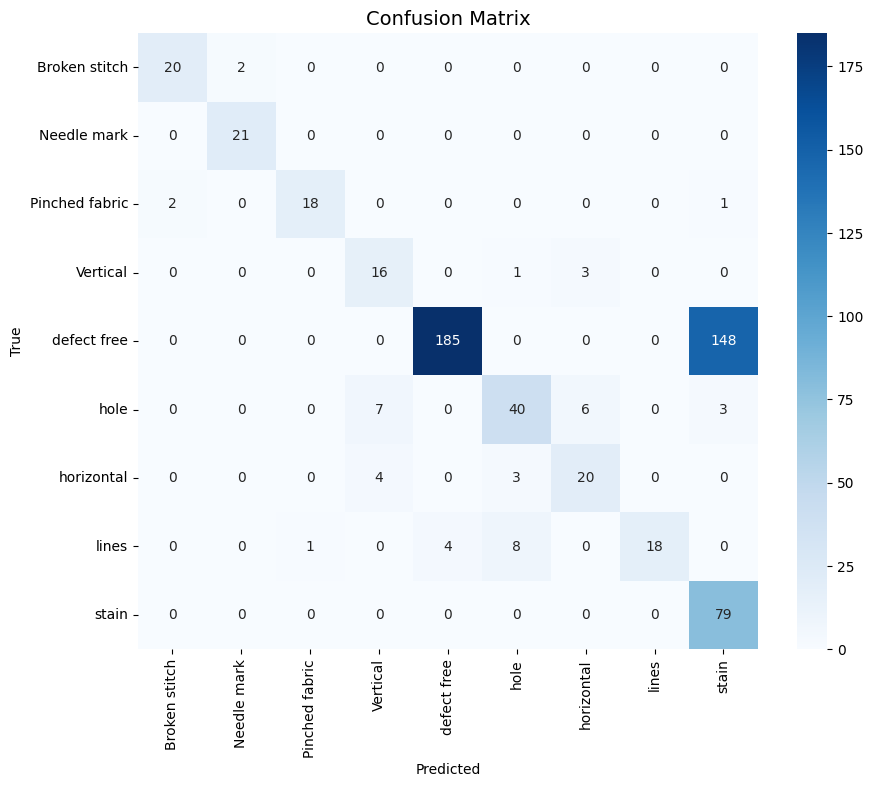

                precision    recall  f1-score   support

 Broken stitch       0.91      0.91      0.91        22
   Needle mark       0.91      1.00      0.95        21
Pinched fabric       0.95      0.86      0.90        21
      Vertical       0.59      0.80      0.68        20
   defect free       0.98      0.56      0.71       333
          hole       0.77      0.71      0.74        56
    horizontal       0.69      0.74      0.71        27
         lines       1.00      0.58      0.73        31
         stain       0.34      1.00      0.51        79

      accuracy                           0.68       610
     macro avg       0.79      0.80      0.76       610
  weighted avg       0.85      0.68      0.71       610



In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves', fontsize=14)
plt.legend()
plt.show()

# Confusion Matrix
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=classes))

In [ ]:
# Load best model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


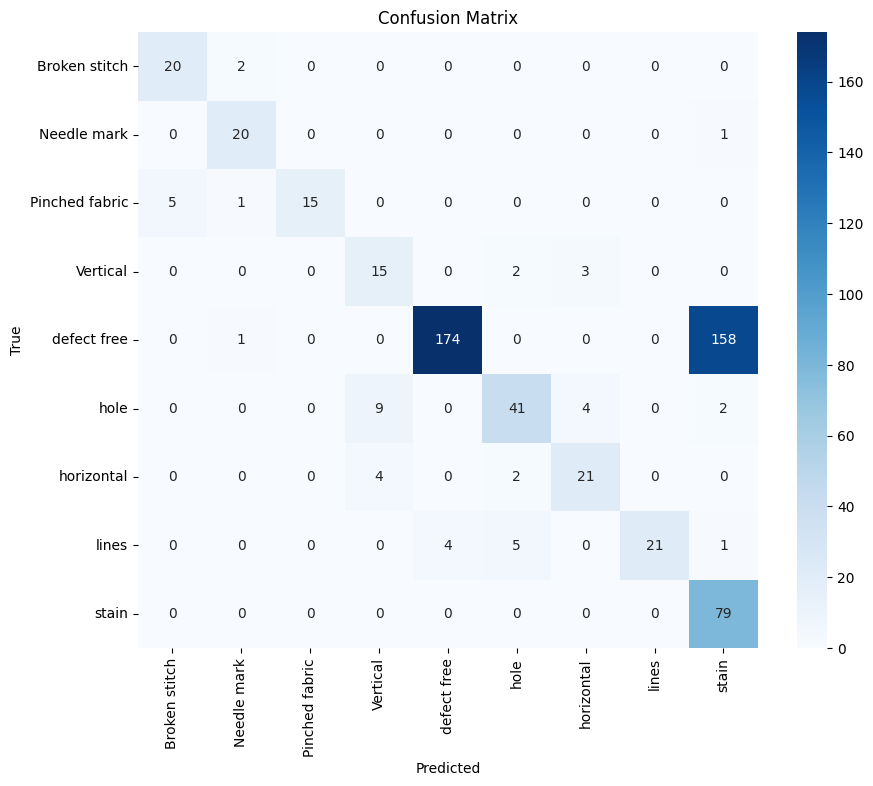

In [ ]:
# Confusion matrix
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Classification report
print(classification_report(y_true, y_pred_classes, target_names=classes))


In [ ]:
def test_random_images(num_images=5):
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        idx = np.random.randint(0, len(val_generator.filenames))
        img_path = os.path.join(data_dir, val_generator.filenames[idx])
        true_class = val_generator.filenames[idx].split('/')[0]

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        # Test-Time Augmentation
        preds = []
        for _ in range(5):  # 5 augmentations
            aug_img = train_datagen.random_transform(img_array.copy())
            pred = model.predict(np.expand_dims(aug_img, axis=0))
            preds.append(pred)
        avg_pred = np.mean(preds, axis=0)

        pred_class = classes[np.argmax(avg_pred)]
        confidence = np.max(avg_pred)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        color = 'green' if pred_class == true_class else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}",
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

test_random_images(5)


In [ ]:
model.save('fabric_defect_model.h5')

# Convert to TFLite (quantized)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('fabric_defect_model_quant.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved in .h5 and quantized TFLite formats")

Saved artifact at '/tmp/tmpng_lcjpx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  140381033863248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033866320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033866128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033865744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033866896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033865360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033866512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033866704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033864784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381033867856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403810338672

In [ ]:
from google.colab import files

# Download the saved model files
files.download('fabric_defect_model.h5')
files.download('fabric_defect_model_quant.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>